This code is adapted from the EXCELLENT tutorial by george7378 at instructables.com. I highly recommend looking at his tutorial as well if you're interested in this project.

The tutorial can be found at: http://www.instructables.com/id/Super-Simple-Raspberry-Pi-433MHz-Home-Automation/

My own modifications are largely housekeeping. Moving code from Python 2 to Python 3, but I also wrote a few lines of code to find the length of the impulses and pauses for me, since I wasn't having much luck doing it manually.

### What this code does:

I have an RF receiver chip connected to my Raspberry Pi. It's wired to GPIO pin 21 - if you're following along just go ahead and replace that line with your own pin number.

When I call the function start_recording(), my Pi begins recording the input from the RF transmitter chip, and stores the time since the recording began and the value of the pin (0 or 1) in a list. Once its done receiving, it returns this list. So, here's how this process works:

1. Run start_recording() while you hit the button on your remote. You'll get the best results if you do this right next to the RF receiver chip you have wired into your Pi.
2. Now you can plot the data and see what the RF packet looks like! You can zoom in and see the long and short impulses that make up your device's signal.
3. Get the code for each outlet. You can do this by zooming in and writing down the long and short impulses as 1s and 0s.
4. Get the timing for the 1s and 0s. You can either zoom in and do this manually by noting the time when a long impulse begins and ends, or you can use the code I wrote below.
5. Now you're ready to write some code to control your device!

In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import RPi.GPIO as GPIO

In [2]:
%matplotlib inline

All of this code is from the instructable I mentioned at the top of the page. *All I did was change it from Python 2 to Python 3 and add some more comments.* I'll clarify one more point up here.

The line: 
```python
GPIO.setmode(GPIO.BCM)
``` 
is explicitely setting the numbering scheme used to refer to the GPIO pins. If you're confused about board versus broadcom numbering, you can take a look at this [excellent stackexchange thread.](https://raspberrypi.stackexchange.com/questions/12966/what-is-the-difference-between-board-and-bcm-for-gpio-pin-numbering)

If you have more questions about the GPIO module, there is an excellent wiki that you can [find here](https://sourceforge.net/p/raspberry-gpio-python/wiki/BasicUsage/)

In [6]:
def start_recording():
    '''
    Output:
        A list containing two columns. The first column is the 
        time in seconds when each reading was taken. The second
        column will be the state of the pin at the time of the 
        reading.
    '''
    # making the list where we're going to store our readings!
    RECEIVED_SIGNAL = [[], []]
    MAX_DURATION = 2  # This is how long we run the program in seconds
    RECEIVE_PIN = 21  # The GPIO pin our receiver is wired to
    GPIO.setmode(GPIO.BCM)  
    GPIO.setup(RECEIVE_PIN, GPIO.IN) # You need to explicitly declare whether a pin is
                                     # input or output, otherwise you'll get an error
    cumulative_time = 0     
    beginning_time = datetime.now()
    print('**Started recording**')
    while cumulative_time < MAX_DURATION:
        time_delta = datetime.now() - beginning_time
        RECEIVED_SIGNAL[0].append(time_delta)
        RECEIVED_SIGNAL[1].append(GPIO.input(RECEIVE_PIN))
        cumulative_time = time_delta.seconds
    print('**Ended recording**')
    print(len(RECEIVED_SIGNAL[0]), 'samples recorded')
    GPIO.cleanup()  # It's always good practice to clean up any resources you've used :)
    print('**Processing results**')
    '''
    Right now the first column of our list contains datetime objects. All we're interested
    in is the time in seconds and microseconds since the program began. These few lines below
    loop through each value in our list and pull only the seconds and microseconds from the
    datetime object. 
    '''
    for i in range(len(RECEIVED_SIGNAL[0])):
        RECEIVED_SIGNAL[0][i] = RECEIVED_SIGNAL[0][i].seconds + RECEIVED_SIGNAL[0][i].microseconds/1000000.0
    print('**Plotting results**')
    plt.plot(RECEIVED_SIGNAL[0], RECEIVED_SIGNAL[1]) # Now we plot our results!
    plt.axis([0, MAX_DURATION, -1, 2])
    plt.show()
    return RECEIVED_SIGNAL

## So, now we have a list containing the time difference (distance along the x-axis), and the value the GPIO pin received

3 seconds...
2 seconds...
1 seconds...
**Started recording**
**Ended recording**
127690 samples recorded
**Processing results**
**Plotting results**


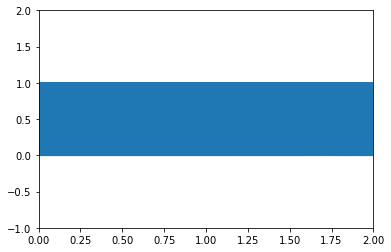

In [7]:
import time 
for i in range(3):
    # I just added a delay because I had to get up from my laptop and walk
    # over to the Pi.
    print(3-i,'seconds...')
    time.sleep(1)
one_on = start_recording()

### There's about 8.5 in .2 seconds, so let's say that there are 85 repetitions of the signal 

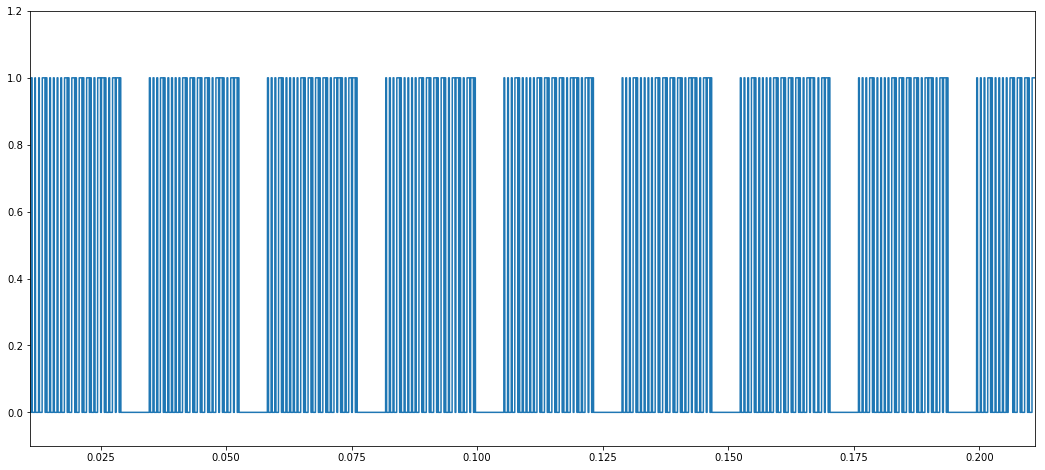

In [19]:
# One On
fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(111)
ax.plot(one_on[0], one_on[1])
ax.axis([0.011, .211, -.1, 1.2])
plt.show()

### OK - now we're getting into my code.

In [51]:
import numpy as np

# Here I have a list comp that loops through the pin states (1 or 0) in our
# output list, and checks to see if they're the same as the value that comes next.
# If they're different, I say 'This is where a change between 1 and 0 took place,'
# and I give it a value of True.
change_pins = [one_on[1][i] != one_on[1][i+1] for i in range(len(one_on[1])-1)]

# Using the np.where() function, I can see the index of the True values - i.e. the
# index of the entry where the pin changed values.
# ...well, slightly to the left of it anyway. It's fine as long as we're consistent.
change_index = np.where(change_pins)[0] 

I don't know where you are as far as learning Python, so I'll rewrite this with a normal for loop:

In [ ]:
# The same as:
change_pins = []
for i in range(len(one_on[1])-1):
    change_bool = (one_on[1][i] != one_on[1][i+1])
    change_pins.append(change_bool)
change_index = np.where(change_pins)[0]

In [6]:
change_pins = []
for i in range(len(rf_array[1])-1):
    change_bool = (rf_array[1][i] != rf_array[1][i+1])
    change_pins.append(change_bool)
change_index = np.where(change_pins)[0]

### If we take the values in change_index, and we retrieve the values from our list of RF data, we can get the time and pin number for each change event. 

In [63]:
rf_array = np.array(one_on)
rf_array[1][change_index][:10] # this alternates 0,1,0,1 - just like it should!

array([ 1.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,  0.])

In [65]:
# Let's just check to see that nothing's broken (because I'm paranoid). Should return an empty array.
np.where(np.array([rf_array[1][change_index[i]] == rf_array[1][change_index[i+1]] for i in range(len(change_index)-1)]))

(array([], dtype=int32),)

### Alright. Now I want to make an array that contains all the time-lengths we're interested in. 
That is to say, I want the duration of:
1. Each '1' impulse
2. The pause that follows each '1'
3. Each '0' impulse
4. The pause between each '0'
5. The longer pause that separates the packets

I do it with a tidy list comp, down below.

In [7]:
delta_times = np.array([(rf_array[0][change_index[i+1]] - rf_array[0][change_index[i]]) for i in range(len(change_index)-1)])
delta_times

array([ 0.000209,  0.000546,  0.000181, ...,  0.000476,  0.00062 ,
        0.000125])

This is the same as:

In [8]:
delta_times = []
for i in range(len(change_index)-1):
    # get the difference between the time when the pin changed values, and the next
    # time it changed values (length of impulse or pause).
    d_time = rf_array[0][change_index[i+1]] - rf_array[0][change_index[i]]
    delta_times.append(d_time)
delta_times = np.array(delta_times) # Being in a numpy array makes things easier later
delta_times 

array([ 0.000209,  0.000546,  0.000181, ...,  0.000476,  0.00062 ,
        0.000125])

In [9]:
np.unique(delta_times, return_counts = True)

(array([  1.40000000e-05,   1.40000000e-05,   1.50000000e-05, ...,
          5.71900000e-03,   5.72100000e-03,   5.72200000e-03]),
 array([1, 6, 3, ..., 1, 1, 1]))

Just by looking at the graph of the signal, we know there are 5 time incriments we want to find: short impulse on, short impulse off, long impulse on, long impulse off, and the delay between packets. 

Let's impliment a very, very simple version of K-Means to group delta_times into 5 groups.

### The simplest possible K-Means Algorithm
Seriously, don't get impressed. This is super simple. Let me walk you through what's going on :)

K-Means is a very simple unsupervised machine learning algorithm. It's a clustering algorithm, meaning that the program is going to try to separate the data into groups that 'make sense.' 
1. Select a value for K (i.e., how many clusters will the program try to find).
    * This is easy for us, since we know just by looking at the data that there are 5 impulses/pauses
2. Choose K centroids
    * There are a few different ways we could go about this, but the easiest is to choose the centroids at random from our data. That's what I do below
3. Calculate the distance between each datapoint and each centroid. 
    * If this data had more dimensionality we would have a lot of options, but here it's just the difference
4. Assign each datapoint to the nearest centroid.
5. Replace the value of each centroid with the average of that centroid's cluster. 
6. Repeat until you meet your stopping criteria. 
    * There are a lot of sophisticated ways to determine when you've reached convergence. This is a very simple problem though, so I just had it run for 50 iterations and stop. 

Step 2: Randomly choosing our centroids from our data 

```python
import random
k = 5
centroids = random.sample(list(delta_times),5)
```

Step 3: Calculate the difference between each value, and each centroid

We go through our datapoints one at a time, and for each datapoint we loop through our list of centroids. We calculate the absolute value of the difference, and then we append the result to a list.
```python
# cent_dict = dict() # we'll get to this in a bit
for v,i in enumerate(delta_times):
    i_dist = []
    for j in centroids:
        i_dist.append(abs(i-j))
```

Step 4: Assign each datapoint to the nearest centroid.

Now we find the index of the smallest difference within the i_dist list using [np.argmin()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.argmin.html). This 0-4 index will correspond to the five centroids. Because we're using enumerate as we loop through all of our datapoints, v is the index of this particular datapoint. So we have an integer corresponding to a centroid, and we have the index of the datapoint - now we just need a way to keep track of it all. I decided the best way to go about this was with a dictionary, where the key was the 0-4 index corresponding to a particular centroid, and the value was a list containing the indexes of all the datapoints corresponding to that centroid. 

You'll see that I use the .get() method when I'm adding values to the dictionary, because otherwise the first time I tried to call the dictionary using one of our 0-4 keys it would give me an error. .get() lets you assign a default value that will be returned if there is nothing under that key. 

```python
cent_dict = dict()
# for v,i in enumerate(delta_times): #commented out for clarity
#     i_dist = []
#     for j in centroids:
#         i_dist.append(abs(i-j))
        min_cent = np.argmin(i_dist)
        cent_dict[min_cent] = cent_dict.get(min_cent,[]) + [v]
```

Step 5. Replace the value of each centroid with the average of that centroid's cluster. 

All we're doing here is going through each of our centroids, grabbing the list stored in cent_dict under that key, using np.mean() to get the average, and replacing that centroid with this new value. The additional code you'll see in this loop below is just calculating the standard deviation of each centroid, printing it out, and then storing the value in a list. I just wanted to be sure everything was working - the standard deviation should go down as more similar values are clustered together.

```python
for v,cent in enumerate(centroids):
    cent = np.mean(delta_times[cent_dict[v]])
    centroids[v] = cent
```

In [12]:
import random
k = 5
centroids = random.sample(list(delta_times),5)
std_list = []
max_iter = 50
for i in range(max_iter):
    cent_dict = dict()
    for v,i in enumerate(delta_times):
        i_dist = []
        for j in centroids:
            i_dist.append(abs(i-j))
        min_cent = np.argmin(i_dist)
        cent_dict[min_cent] = cent_dict.get(min_cent,[]) + [v]
    for v,cent in enumerate(centroids):
        std_temp = []
        cent = np.mean(delta_times[cent_dict[v]])
        centroids[v] = cent
        cent_std = np.std(delta_times[cent_dict[v]])
        print('Standard Deviation Centroid',v,cent_std)
        std_temp.append(cent_std)
    std_list.append(std_temp)

Standard Deviation Centroid 0 1.79486017748e-05
Standard Deviation Centroid 1 0.00134341977975
Standard Deviation Centroid 2 3.29892354129e-05
Standard Deviation Centroid 3 1.86670275294e-05
Standard Deviation Centroid 4 3.24959548961e-05
Standard Deviation Centroid 0 1.52358918964e-05
Standard Deviation Centroid 1 0.00114774337736
Standard Deviation Centroid 2 3.29709390481e-05
Standard Deviation Centroid 3 2.04819011467e-05
Standard Deviation Centroid 4 4.59776269615e-05
Standard Deviation Centroid 0 1.50756217675e-05
Standard Deviation Centroid 1 3.19096605433e-05
Standard Deviation Centroid 2 3.30103055582e-05
Standard Deviation Centroid 3 2.06597550479e-05
Standard Deviation Centroid 4 5.65570464431e-05
Standard Deviation Centroid 0 1.50756217675e-05
Standard Deviation Centroid 1 3.19096605433e-05
Standard Deviation Centroid 2 3.30103055582e-05
Standard Deviation Centroid 3 2.06597550479e-05
Standard Deviation Centroid 4 5.65570464431e-05
Standard Deviation Centroid 0 1.5075621767

Standard Deviation Centroid 0 1.50756217675e-05
Standard Deviation Centroid 1 3.19096605433e-05
Standard Deviation Centroid 2 3.30103055582e-05
Standard Deviation Centroid 3 2.06597550479e-05
Standard Deviation Centroid 4 5.65570464431e-05
Standard Deviation Centroid 0 1.50756217675e-05
Standard Deviation Centroid 1 3.19096605433e-05
Standard Deviation Centroid 2 3.30103055582e-05
Standard Deviation Centroid 3 2.06597550479e-05
Standard Deviation Centroid 4 5.65570464431e-05
Standard Deviation Centroid 0 1.50756217675e-05
Standard Deviation Centroid 1 3.19096605433e-05
Standard Deviation Centroid 2 3.30103055582e-05
Standard Deviation Centroid 3 2.06597550479e-05
Standard Deviation Centroid 4 5.65570464431e-05
Standard Deviation Centroid 0 1.50756217675e-05
Standard Deviation Centroid 1 3.19096605433e-05
Standard Deviation Centroid 2 3.30103055582e-05
Standard Deviation Centroid 3 2.06597550479e-05
Standard Deviation Centroid 4 5.65570464431e-05
Standard Deviation Centroid 0 1.50756217

##### centroids

In [13]:
centroids

[0.00019462253829321386,
 0.0056815058823529345,
 0.00014246282973621186,
 0.00026170843989768749,
 0.00054970704086657139]

In [14]:
new_cents = []
for i in range(5):
    dt = delta_times[cent_dict[i]]
    a = np.percentile(dt,75)
    b = np.percentile(dt,25)
    dt = dt[np.where((dt <= a)&(dt >= b))]
    new_cents.append(dt)

In [15]:
for i in new_cents: # OK, this is good. We know that there were about 81 repetitions of 
    print(len(i))   # the delay between signals, and since we just culled out about 1/2 of the
                    # data points, so 43 makes sense.

509
43
423
205
1033


In [16]:
for i in new_cents:
    print(np.mean(i))

0.000195748526523
0.00569055813953
0.000155586288416
0.000258292682927
0.000552709583737


In [17]:
np.std(delta_times[cent_dict[0]])

1.5075621767450843e-05

In [3]:
import numpy as np
import pickle

with open('num_arr.pkl','rb') as f:
    rf_array = pickle.load(f)

In [29]:
centroid_list = [np.mean(c) for c in new_cents]

In [60]:
# from collections import Counter

# delta_new = []
# for i in delta_times:
#     i_list = []
#     for cent in centroid_list:
#         i_list.append(abs(i-np.mean(cent)))
#     #print(i_list)
#     i_new = np.argmin(np.array(i_list))
#     delta_new.append(str(i_new))
# max_cent = str(np.argmax(centroid_list))

# delta_new = ''.join(delta_new).split(max_cent)
# delta_new

from collections import Counter

delta_new = []
for v in range(len(delta_times)):
    v_list = []
    for i in range(len(centroid_list)):
        if v in cent_dict[i]:
            delta_new.append(str(i))
            
max_cent = str(np.argmax(centroid_list))
delta_new = ''.join(delta_new).split(max_cent)
delta_new

['040040440400',
 '0424244004040404044004400440044004044040040440400',
 '0404044004040404044004400440044004044040040440400',
 '0404044004040404044004400440044004044040040440400',
 '0404044004040404044004400440044004044040040440400',
 '0404044204040404044004400440044004044040040440400',
 '0404044004040404044004420440044004044040040440400',
 '0404044004040404044004400440044004044040240440400',
 '0404044004040404044004400440044004044040040440400',
 '040404400404040400400440044024444040040440402',
 '0404044004040404244004400440244004044040040440402',
 '0404244004240404044024402440044004244040240440400',
 '0404044004240404044004402440044004044040242440400',
 '0424044024240424044024402440244004044040242440402',
 '2424244004242424044024402440244024244040242440402',
 '2424244024242424244024402440244024244040242440402',
 '2424244324242424244004402440244024244040242440402',
 '2424244024242424244024402440244024244040242440402',
 '2424244024242424244024402440244024244040242440402',
 '2424244024242

In [2]:
#max_cent

In [61]:
c = Counter(delta_new)
c.most_common(3)

[('2424244024242424244024402440244024244040242440402', 19),
 ('0404044004040404044004400440044004044040040440400', 4),
 ('3434344234343434344234423442344234344242343442423', 4)]

So, what do we have going on here?

We split on '1', leaving us with 0,2,3, and 4 to work with. But it looks like 3 isn't used at all in our most common code. When we look closer, we see that 0 and 4 appear twice in a row in several places. 

In [57]:
c = Counter(delta_new)
c.most_common(3)

[('2424244024242424244024402440244024244040242440402', 21),
 ('3434344234343434344234423442344234344242343442423', 4),
 ('0404044004040404044004400440044004044040240440400', 2)]

Awesome - we have our rf packet without having to zoom and pan!

Let's see which of these options works.

In [51]:
len(delta_new)

86

In [49]:
max_cent

'1'

In [4]:
rf_array

array([[  1.17000000e-03,   1.24800000e-03,   1.28400000e-03, ...,
          1.99997100e+00,   1.99998500e+00,   2.00000000e+00],
       [  1.00000000e+00,   1.00000000e+00,   1.00000000e+00, ...,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00]])

In [30]:
cent_dict[0]

[765,
 1751,
 2666,
 2810,
 2858,
 2906,
 3008,
 3014,
 3020,
 3048,
 3056,
 3058,
 3060,
 3080,
 3110,
 3114,
 3116,
 3122,
 3126,
 3130,
 3134,
 3156,
 3160,
 3166,
 3170,
 3172,
 3176,
 3184,
 3196,
 3208,
 3210,
 3214,
 3216,
 3218,
 3220,
 3228,
 3236,
 3240,
 3258,
 3264,
 3268,
 3270,
 3272,
 3274,
 3276,
 3280,
 3284,
 3288,
 3292,
 3294,
 3300,
 3302,
 3310,
 3312,
 3314,
 3318,
 3320,
 3322,
 3324,
 3326,
 3330,
 3334,
 3338,
 3342,
 3352,
 3362,
 3364,
 3366,
 3370,
 3372,
 3374,
 3376,
 3378,
 3384,
 3388,
 3392,
 3398,
 3404,
 3406,
 3414,
 3416,
 3418,
 3426,
 3428,
 3430,
 3432,
 3436,
 3440,
 3444,
 3450,
 3456,
 3458,
 3466,
 3468,
 3470,
 3474,
 3476,
 3478,
 3480,
 3482,
 3486,
 3490,
 3494,
 3498,
 3500,
 3506,
 3508,
 3516,
 3518,
 3520,
 3524,
 3526,
 3528,
 3530,
 3532,
 3536,
 3542,
 3546,
 3550,
 3552,
 3558,
 3568,
 3570,
 3572,
 3582,
 3584,
 3586,
 3588,
 3592,
 3596,
 3600,
 3606,
 3614,
 3622,
 3624,
 3626,
 3630,
 3632,
 3634,
 3636,
 3638,
 3642,
 3646,


In [27]:
cent_dict[0]

[765,
 1751,
 2666,
 2810,
 2858,
 2906,
 3008,
 3014,
 3020,
 3048,
 3056,
 3058,
 3060,
 3080,
 3110,
 3114,
 3116,
 3122,
 3126,
 3130,
 3134,
 3156,
 3160,
 3166,
 3170,
 3172,
 3176,
 3184,
 3196,
 3208,
 3210,
 3214,
 3216,
 3218,
 3220,
 3228,
 3236,
 3240,
 3258,
 3264,
 3268,
 3270,
 3272,
 3274,
 3276,
 3280,
 3284,
 3288,
 3292,
 3294,
 3300,
 3302,
 3310,
 3312,
 3314,
 3318,
 3320,
 3322,
 3324,
 3326,
 3330,
 3334,
 3338,
 3342,
 3352,
 3362,
 3364,
 3366,
 3370,
 3372,
 3374,
 3376,
 3378,
 3384,
 3388,
 3392,
 3398,
 3404,
 3406,
 3414,
 3416,
 3418,
 3426,
 3428,
 3430,
 3432,
 3436,
 3440,
 3444,
 3450,
 3456,
 3458,
 3466,
 3468,
 3470,
 3474,
 3476,
 3478,
 3480,
 3482,
 3486,
 3490,
 3494,
 3498,
 3500,
 3506,
 3508,
 3516,
 3518,
 3520,
 3524,
 3526,
 3528,
 3530,
 3532,
 3536,
 3542,
 3546,
 3550,
 3552,
 3558,
 3568,
 3570,
 3572,
 3582,
 3584,
 3586,
 3588,
 3592,
 3596,
 3600,
 3606,
 3614,
 3622,
 3624,
 3626,
 3630,
 3632,
 3634,
 3636,
 3638,
 3642,
 3646,


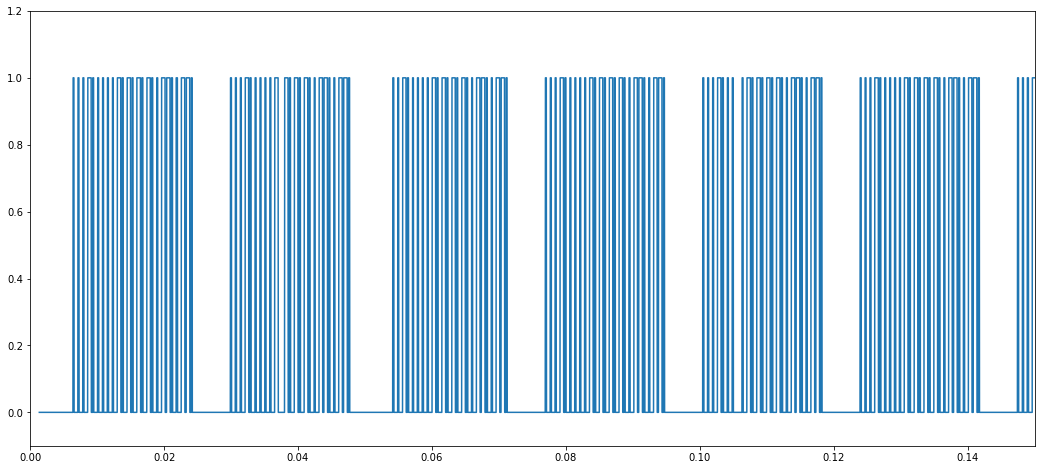

In [28]:
# One On
fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(111)
ax.plot(RECEIVED_SIGNAL[0], RECEIVED_SIGNAL[1])
ax.axis([0, .15, -.1, 1.2])
plt.show()

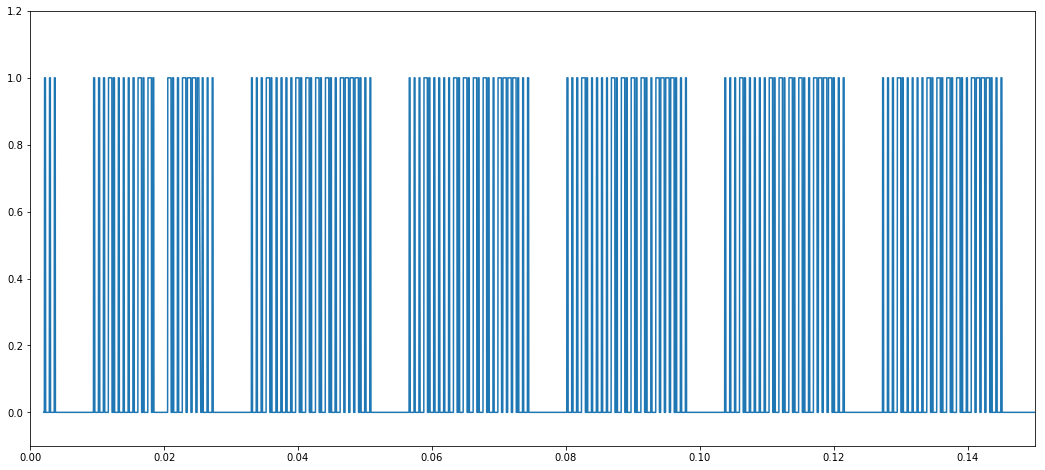

In [31]:
# One Off
fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(111)
ax.plot(one_off[0], one_off[1])
ax.axis([0, .15, -.1, 1.2])
plt.show()

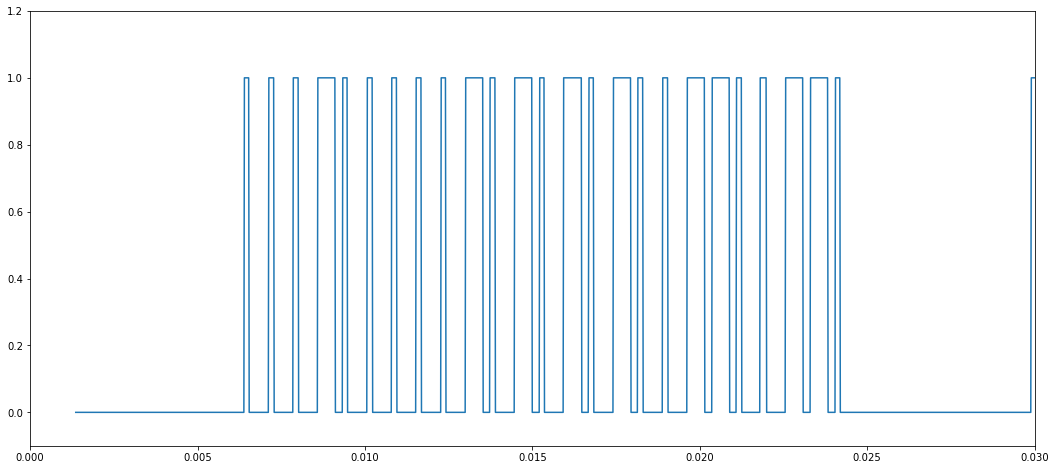

In [6]:
fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(111)
ax.plot(RECEIVED_SIGNAL[0], RECEIVED_SIGNAL[1])
ax.axis([0, .03, -.1, 1.2])
plt.show()

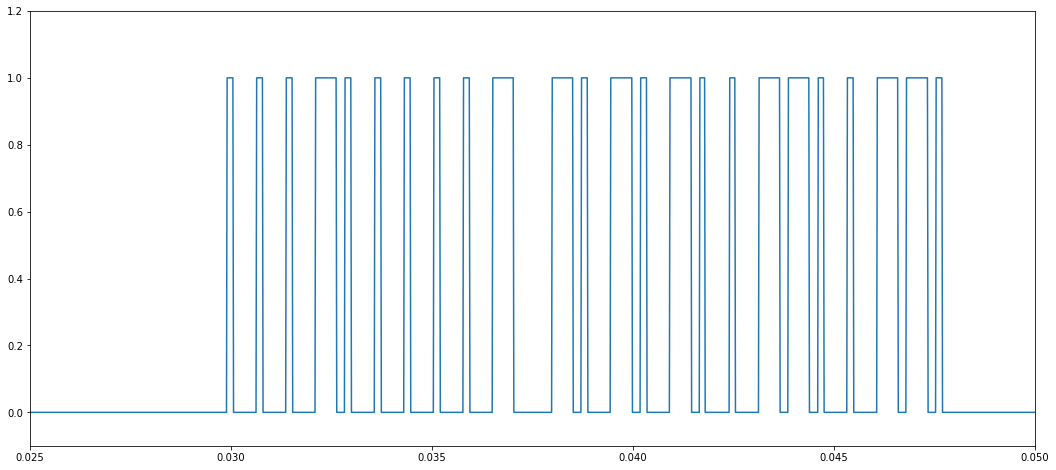

In [10]:
fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(111)
ax.plot(RECEIVED_SIGNAL[0], RECEIVED_SIGNAL[1])
ax.axis([0.025, .05, -.1, 1.2])
plt.show()

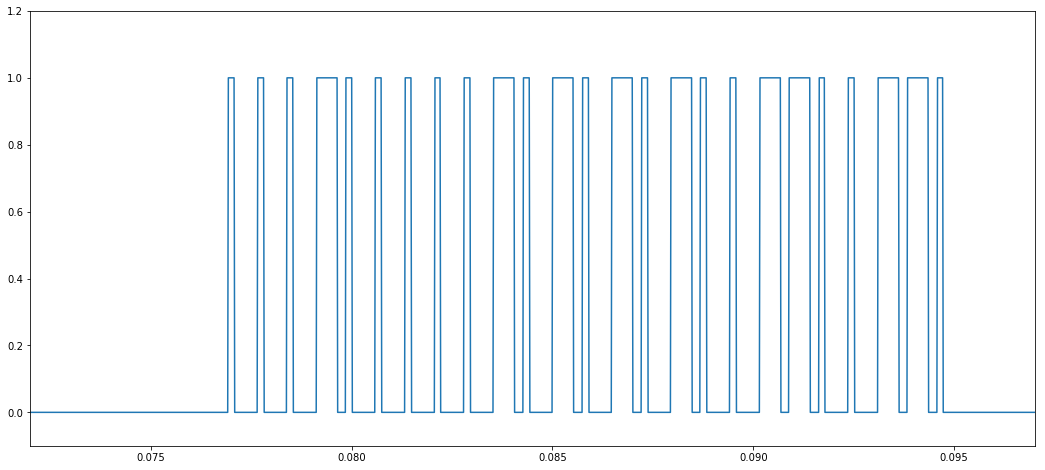

In [19]:
fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(111)
ax.plot(RECEIVED_SIGNAL[0], RECEIVED_SIGNAL[1])
ax.axis([0.072, .097, -.1, 1.2])
plt.show()

# For Number One ON:
000 - 1 - 00000 - 10101010 - 0110 - 0110

**Started recording**
**Ended recording**
331886 samples recorded
**Processing results**
**Plotting results**


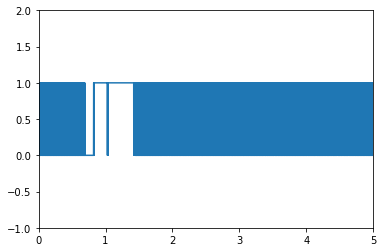

In [25]:
one_off = start_recording()

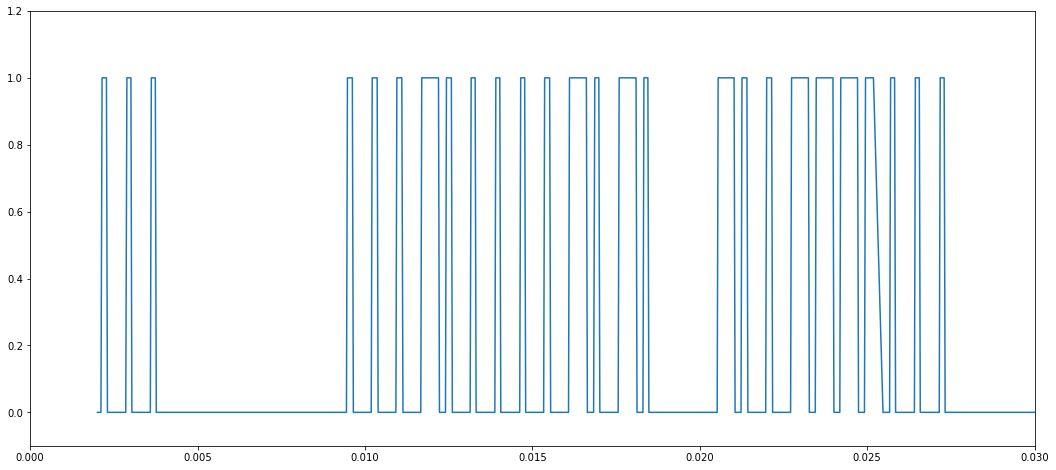

In [29]:
fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(111)
ax.plot(one_off[0], one_off[1])
ax.axis([0, .03, -.1, 1.2])
plt.show()

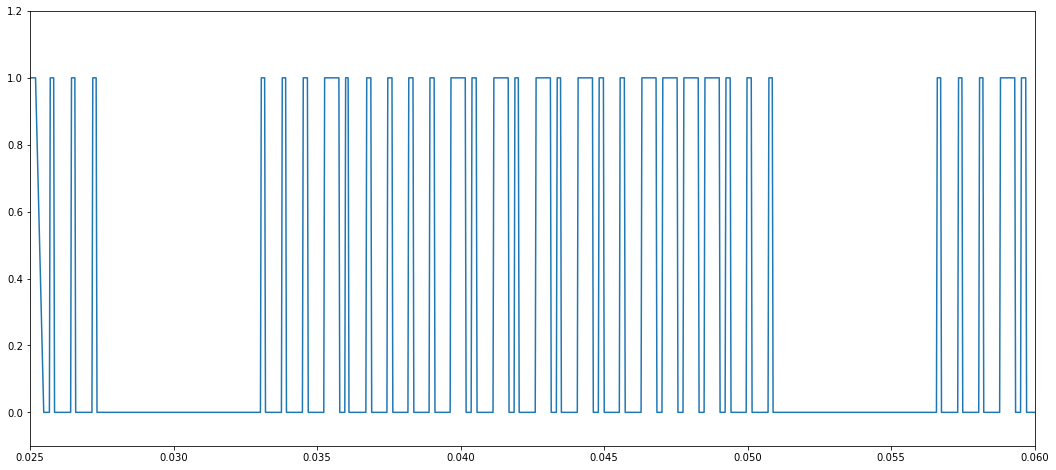

In [35]:
fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(111)
ax.plot(one_off[0], one_off[1])
ax.axis([0.025, .06, -.1, 1.2])
plt.show()

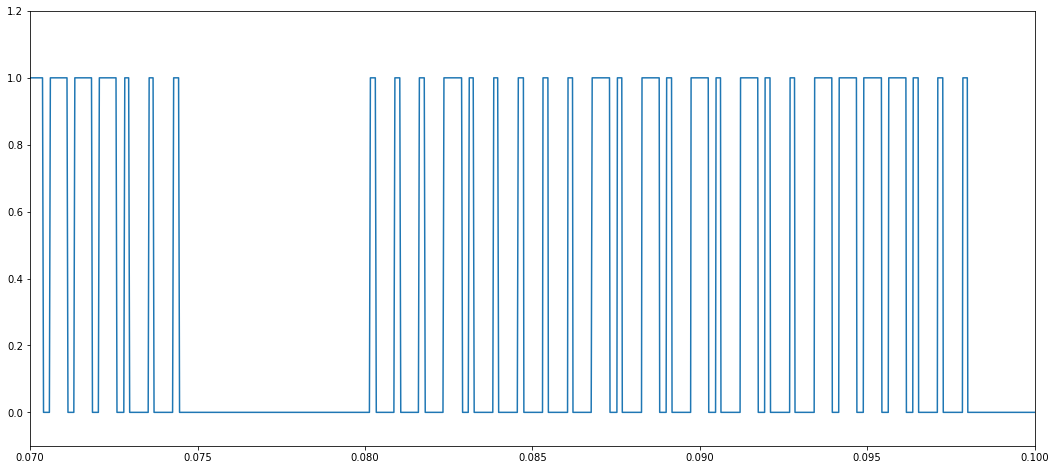

In [34]:
fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(111)
ax.plot(one_off[0], one_off[1])
ax.axis([0.07, .1, -.1, 1.2])
plt.show()

One On: 000-1-00000-10101010-0110-0110
One Off: 000-1-00000-10101010-01111000

**Started recording**
**Ended recording**
330210 samples recorded
**Processing results**
**Plotting results**


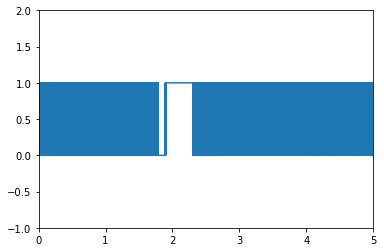

In [50]:
two_on = start_recording()

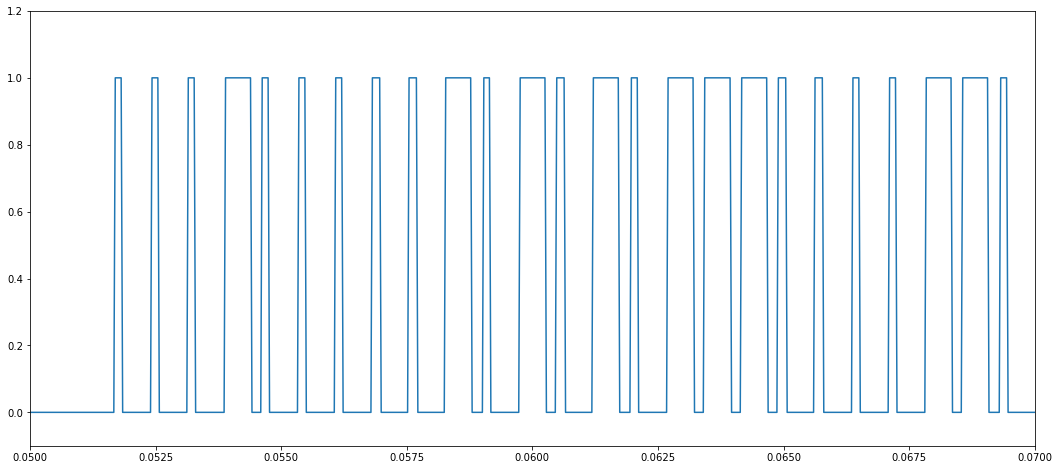

In [57]:
fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(111)
ax.plot(two_on[0], two_on[1])
ax.axis([0.05, .07, -.1, 1.2])
plt.show()

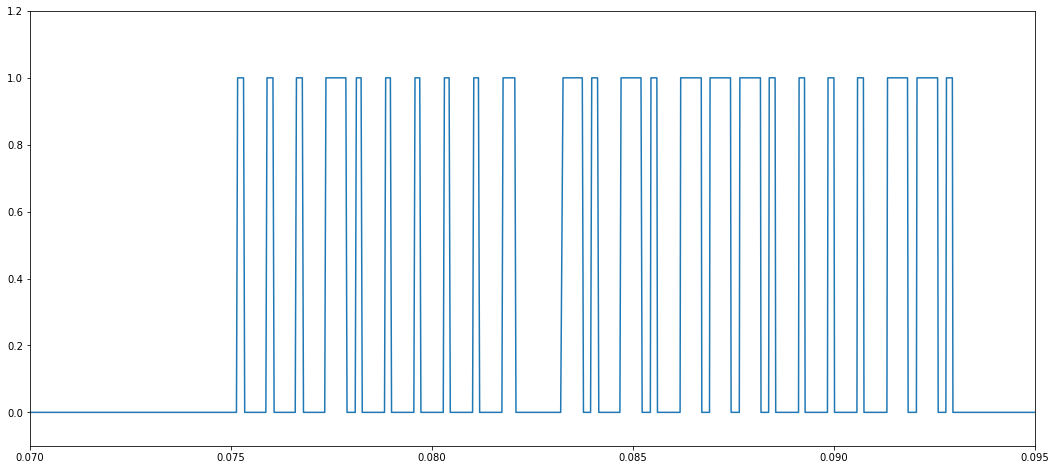

In [56]:
fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(111)
ax.plot(two_on[0], two_on[1])
ax.axis([0.07, .095, -.1, 1.2])
plt.show()

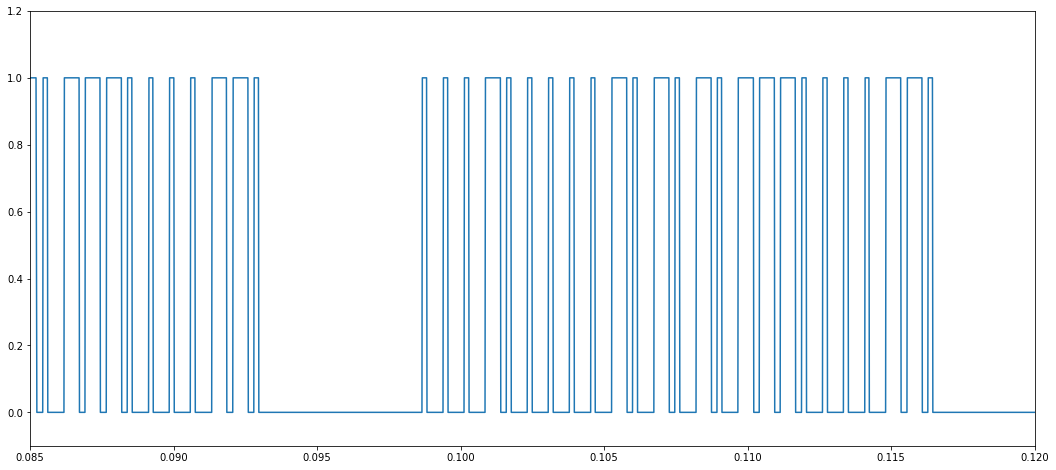

In [53]:
fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(111)
ax.plot(two_on[0], two_on[1])
ax.axis([0.085, .12, -.1, 1.2])
plt.show()

**Started recording**
**Ended recording**
332738 samples recorded
**Processing results**
**Plotting results**


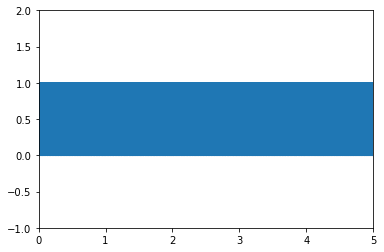

In [58]:
two_off = start_recording()

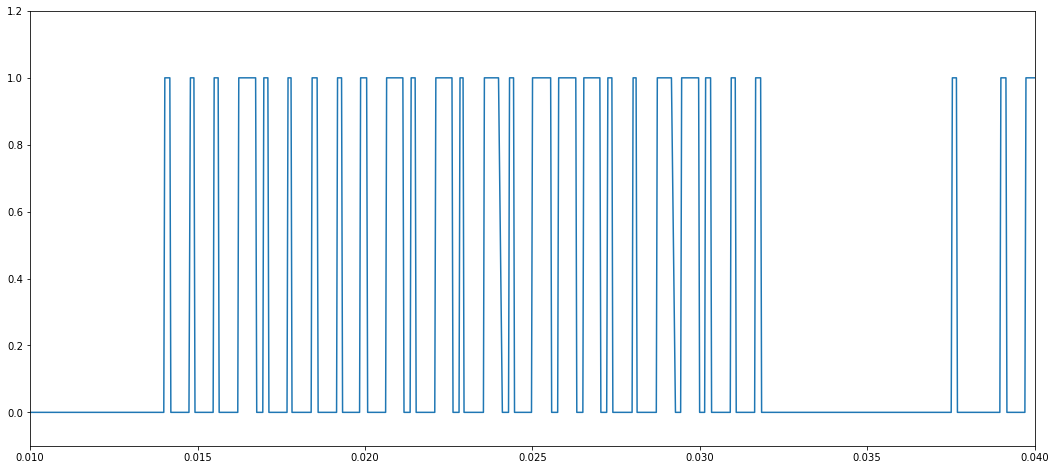

In [61]:
fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(111)
ax.plot(two_off[0], two_off[1])
ax.axis([0.01, .04, -.1, 1.2])
plt.show()

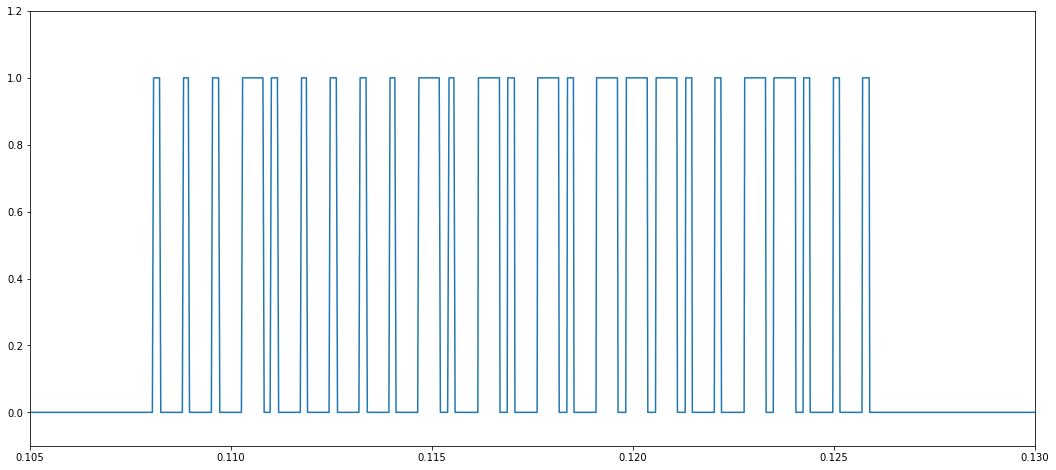

In [67]:
fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(111)
ax.plot(two_off[0], two_off[1])
ax.axis([0.105, .13, -.1, 1.2])
plt.show()

**Started recording**
**Ended recording**
128159 samples recorded
**Processing results**
**Plotting results**


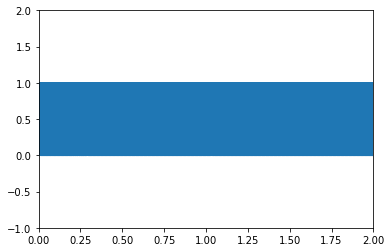

In [69]:
three_on = start_recording()

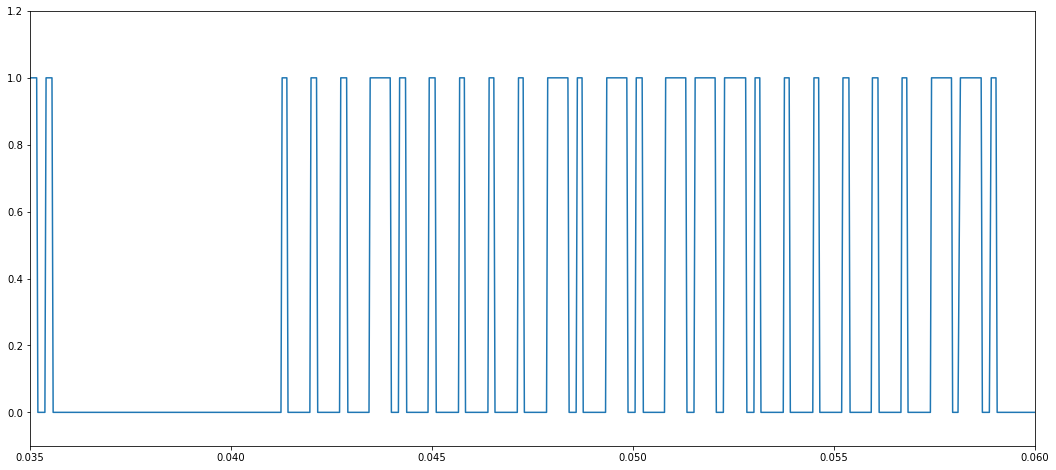

In [71]:
fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(111)
ax.plot(three_on[0], three_on[1])
ax.axis([0.035, .06, -.1, 1.2])
plt.show()

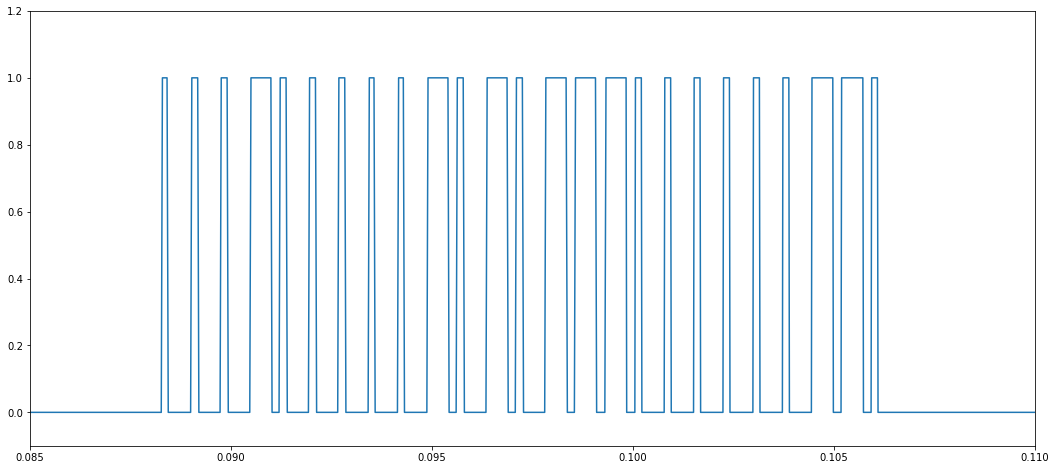

In [74]:
fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(111)
ax.plot(three_on[0], three_on[1])
ax.axis([0.085, .11, -.1, 1.2])
plt.show()

**Started recording**
**Ended recording**
129072 samples recorded
**Processing results**
**Plotting results**


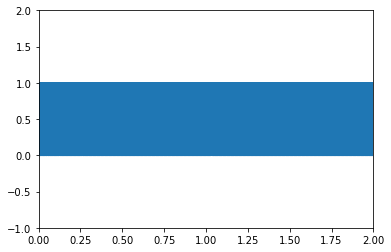

In [75]:
three_off = start_recording()

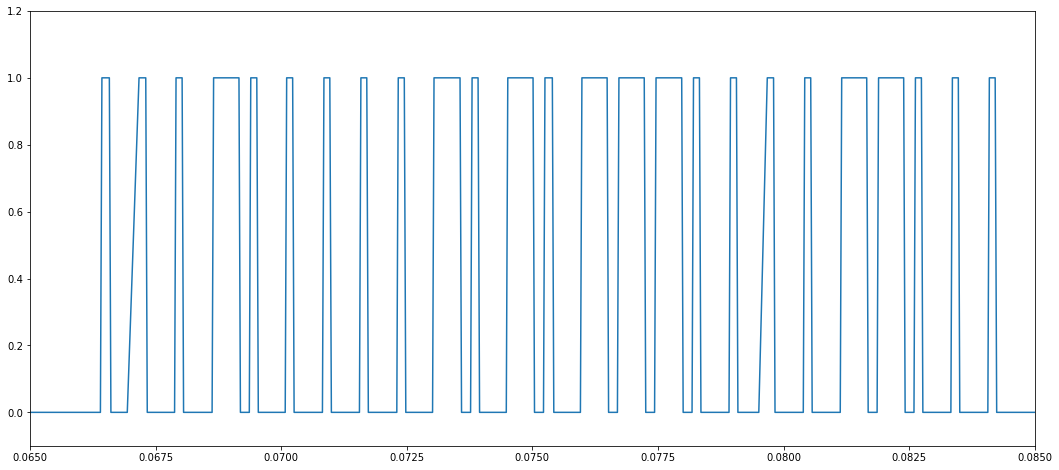

In [80]:
fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(111)
ax.plot(three_off[0], three_off[1])
ax.axis([0.065, .085, -.1, 1.2])
plt.show()

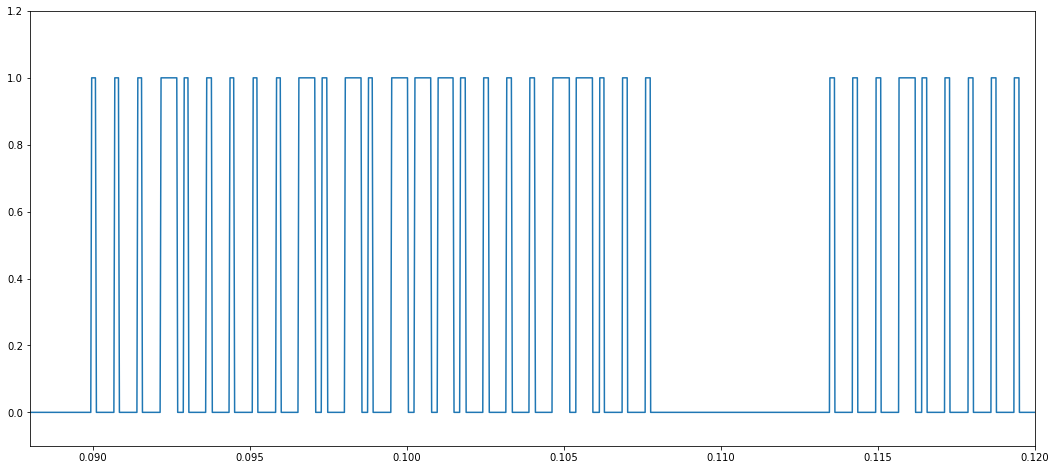

In [82]:
fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(111)
ax.plot(three_off[0], three_off[1])
ax.axis([0.088, .12, -.1, 1.2])
plt.show()

**Started recording**
**Ended recording**
132716 samples recorded
**Processing results**
**Plotting results**


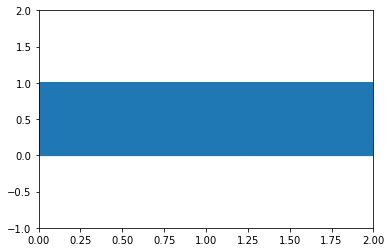

In [87]:
four_on = start_recording()

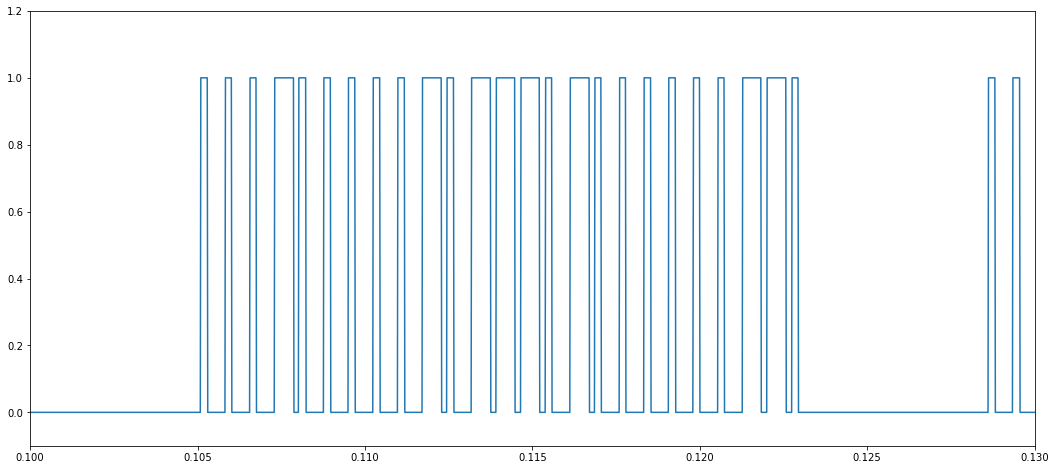

In [93]:
fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(111)
ax.plot(four_on[0], four_on[1])
ax.axis([0.1, .13, -.1, 1.2])
plt.show()

**Started recording**
**Ended recording**
133216 samples recorded
**Processing results**
**Plotting results**


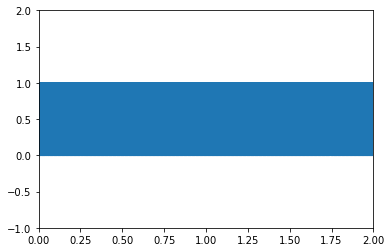

In [94]:
four_off = start_recording()

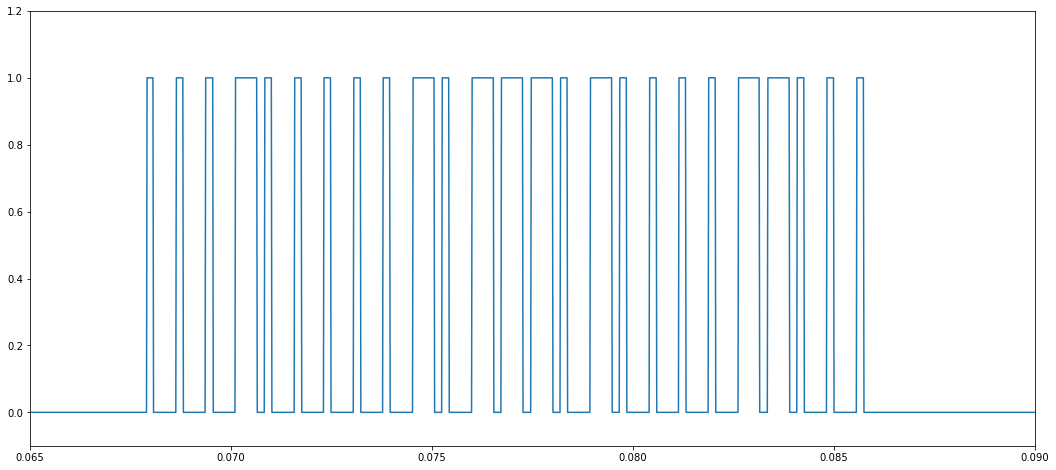

In [109]:
fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(111)
ax.plot(four_off[0], four_off[1])
ax.axis([0.065, .09, -.1, 1.2])
plt.show()

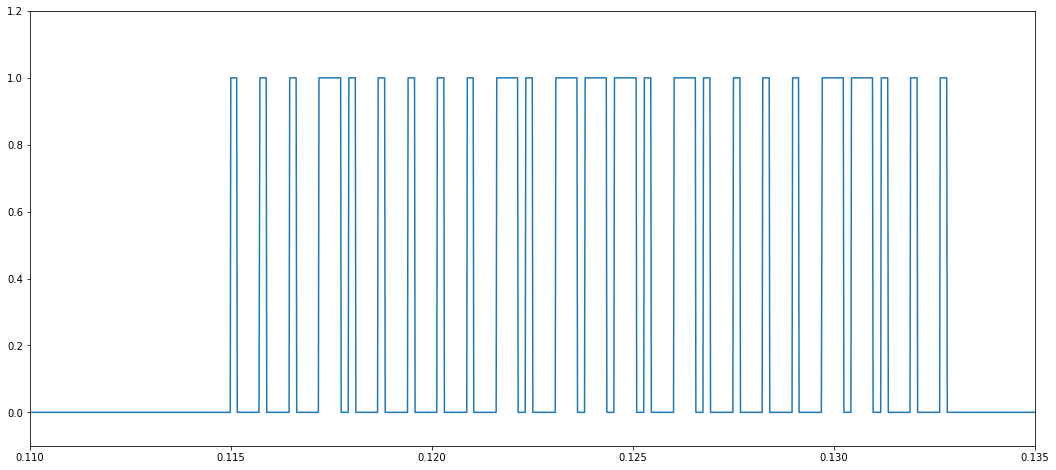

In [105]:
fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(111)
ax.plot(four_off[0], four_off[1])
ax.axis([0.11, .135, -.1, 1.2])
plt.show()

**Started recording**
**Ended recording**
132535 samples recorded
**Processing results**
**Plotting results**


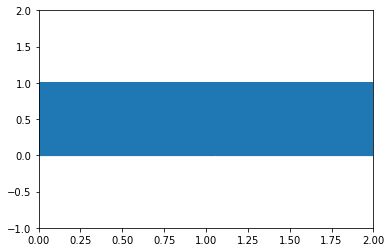

In [110]:
five_on = start_recording()

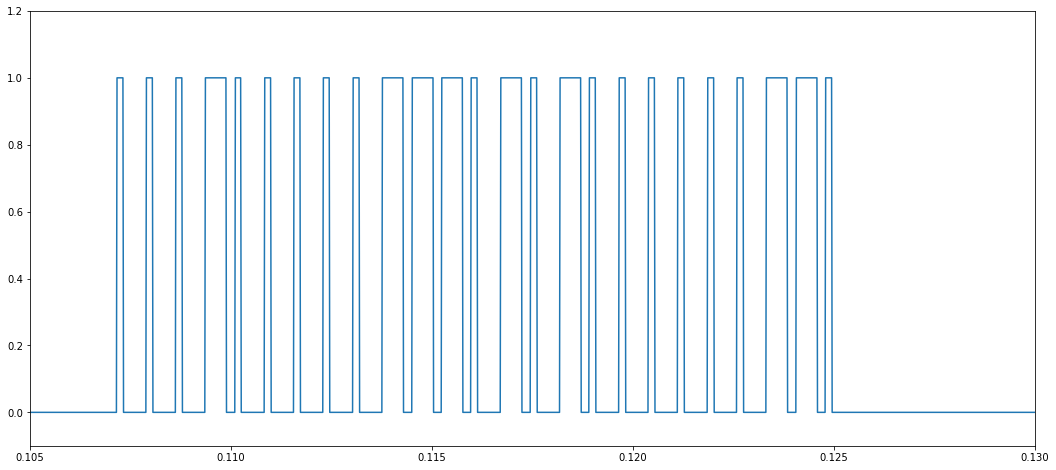

In [118]:
fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(111)
ax.plot(five_on[0], five_on[1])
ax.axis([0.105, .13, -.1, 1.2])
plt.show()

**Started recording**
**Ended recording**
126011 samples recorded
**Processing results**
**Plotting results**


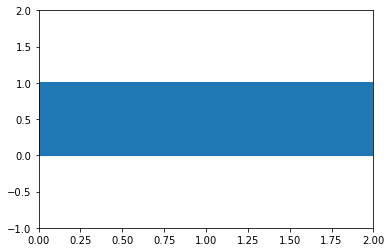

In [125]:
five_off = start_recording()

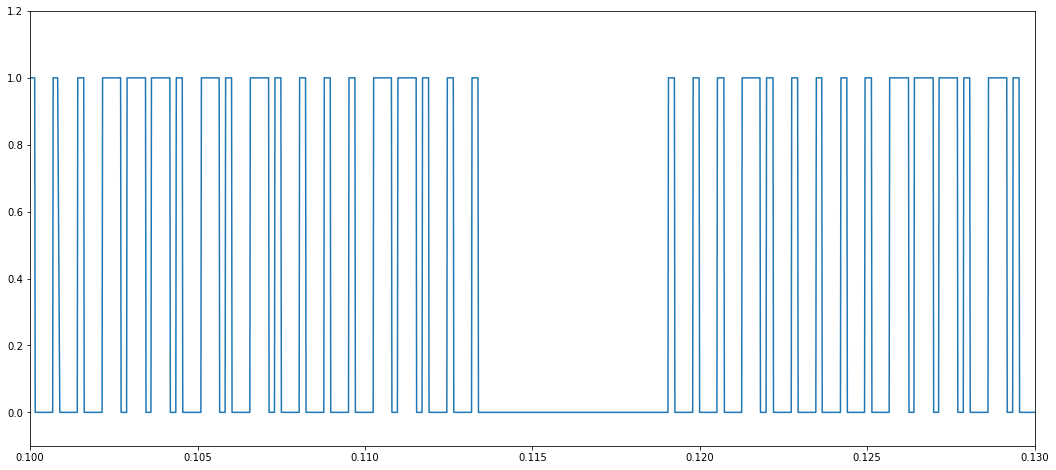

In [146]:
fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(111)
ax.plot(five_off[0], five_off[1])
ax.axis([.1, .13, -.1, 1.2])
plt.show()

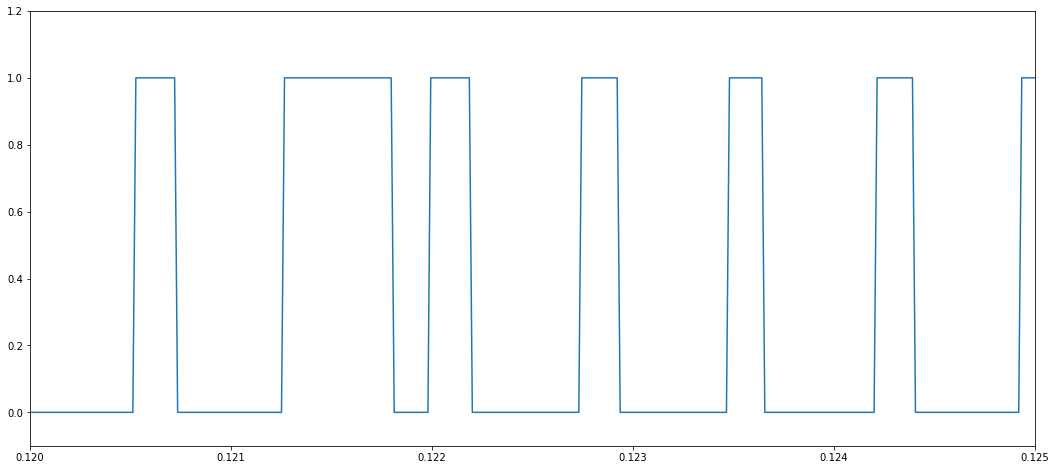

In [150]:
fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(111)
ax.plot(five_off[0], five_off[1])
ax.axis([.12, .125, -.1, 1.2])
plt.show()

beginning of 0 to end of 0
    0.00094
beginning of 0 to start of 1
    0.000735
beginning of 1 to start of 0
    0.000735
    
Length of 0
    0.00022
    0.00022
Length of 1
    /0.000588
    /0.000588
    0.0005515


five on:
        000-1-00000-11-101010-00000-110
        000-1-00000-11-101010-00000-110
five off:
        000-1-00000-11-101010-000-11-000
        000-1-00000-11-101010-000-11-000

four on:
        000-1-00000-10-11-1010-00000-110
        000-1-00000-10-11-1010-00000-110
four off:
        000-1-00000-10-11-1010-00011-000
        000-1-00000-10-11-1010-00011-000
        
three on:
        000-1-00000-1010-111-000000-110
        000-1-00000-1010-111-000000-110
three off:
        000-1-00000-1010-111-0000-11-000
        000-1-00000-1010-111-0000-11-000

two On: 
        000-1-00000-101010-111-0000-110
two off:
        000-1-00000-101010-111-00-11-000
        000-1-00000-101010-111-00-11-000
One On: 
        000-1-00000-10101010-01100-110
One Off: 
        000-1-00000-10101010-01111-000

        

In [5]:
code_dict = {'five_on': '0001000001 1101010000 00110',
            'five_off': '0001000001 1101010000 11000',
            'four_on':  '0001000001 0111010000 00110',
            'four_off': '0001000001 0111010000 11000',
            'three_on': '0001000001 0101110000 00110',
            'three_off':'0001000001 0101110000 11000',
            'two_on':   '0001000001 0101011100 00110',
            'two_off':  '0001000001 0101011100 11000',
            'one_on':   '0001000001 0101010011 00110',
            'one_off':  '0001000001 0101010011 11000'}

In [6]:
code_dict['five_on']

'0001000001 1101010000 00110'

In [7]:
import time
import sys
import RPi.GPIO as GPIO



def transmit_code(code):
    '''Transmit a chosen code string using the GPIO transmitter'''
    code_dict = {'five_on':'0001000001110101000000110',
                'five_off':'0001000001110101000011000',
                'four_on':'0001000001011101000000110',
                'four_off':'0001000001011101000011000',
                'three_on':'0001000001010111000000110',
                'three_off':'0001000001010111000011000',
                'two_on': '0001000001010101110000110',
                'two_off':'0001000001010101110011000',
                'one_on':'0001000001010101001100110',
                'one_off': '0001000001010101001111000'}
    try:
#         code = code_dict[code]
#         atomic_unit = 0.00073529
#         short_impulse = 0.00032027272727272774
#         short_sleep = 0.00041599999999999905
#         long_impulse =  0.00067212500000000041
#         long_sleep = .000051875000000000272
#         extended_delay = 0.00559200000
        code = code_dict[code]
        atomic_unit = 0.0073529
        short_impulse = 0.0032027272727272774
        short_sleep = 0.0041599999999999905
        long_impulse =  0.0067212500000000041
        long_sleep = .00051875000000000272
        extended_delay = 0.0559200000

#         short_impulse = 0.0005
#         short_sleep = 0.0011
#         long_impulse = 0.00125
#         long_sleep = 0.00035
#         extended_delay = 0.01130
#         init_delay = 0.01125

        NUM_ATTEMPTS = 4
        NUM_REPS = 4
        TRANSMIT_PIN = 27

        GPIO.setmode(GPIO.BCM)
        GPIO.setup(TRANSMIT_PIN, GPIO.OUT)

        for t in range(NUM_ATTEMPTS):
            for r in range(NUM_REPS):
                for i in code:
                    if i == '0':
                        GPIO.output(TRANSMIT_PIN, 1)
                        time.sleep(short_impulse)
                        GPIO.output(TRANSMIT_PIN, 0)
                        time.sleep(short_sleep)
                    elif i == '1':
                        GPIO.output(TRANSMIT_PIN, 1)
                        time.sleep(long_impulse)
                        GPIO.output(TRANSMIT_PIN, 0)
                        time.sleep(long_sleep)
                    else:
                        continue
                GPIO.output(TRANSMIT_PIN, 0)
                time.sleep(extended_delay)
        GPIO.cleanup()
    except KeyError:
        print('invalid input')



In [8]:
transmit_code('five_on')

**Started recording**
**Ended recording**
66651 samples recorded
**Processing results**
**Plotting results**


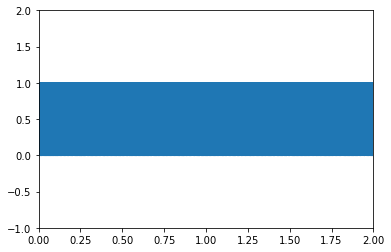

In [9]:
two_off = start_recording()

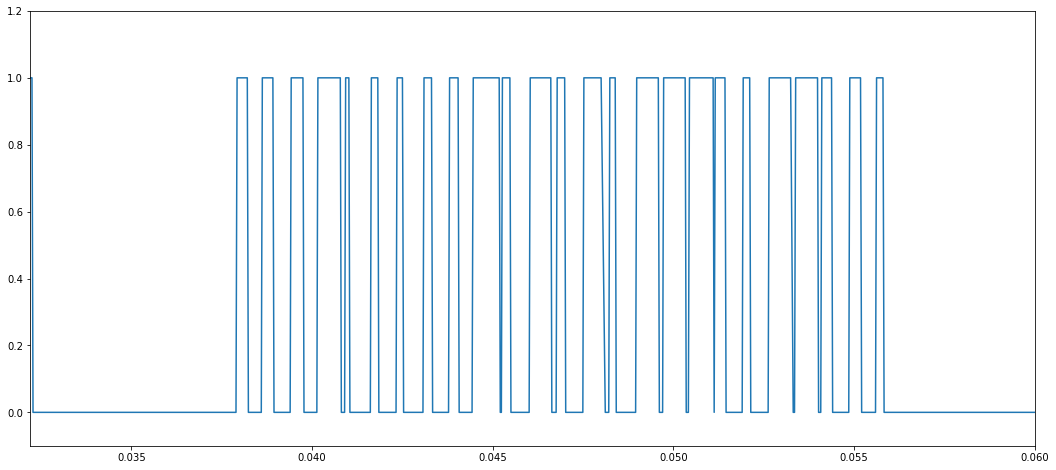

In [28]:
fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(111)
ax.plot(two_off[0], two_off[1])
ax.axis([0.0322, .06, -.1, 1.2])
plt.show()

In [29]:
import numpy as np
pulses = get_pulses(two_off)

In [ ]:
def get_top(received):
    timing = np.array(received[0])
    signal = np.array(received[1])
    np.where(signal == 1)
    
#     a = np.where(np.roll(signal,1)!=signal)[0]
#     pulses = (timing[a][1:] - timing[a][:-1])
    return pulses

In [12]:
code_dict['two_off']
'000 1 00000 101010 111 00 11 000'

'0001000001 0101011100 11000'

**Started recording**
**Ended recording**
67994 samples recorded
**Processing results**
**Plotting results**


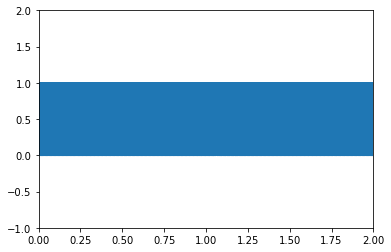

In [19]:
two_on = start_recording()

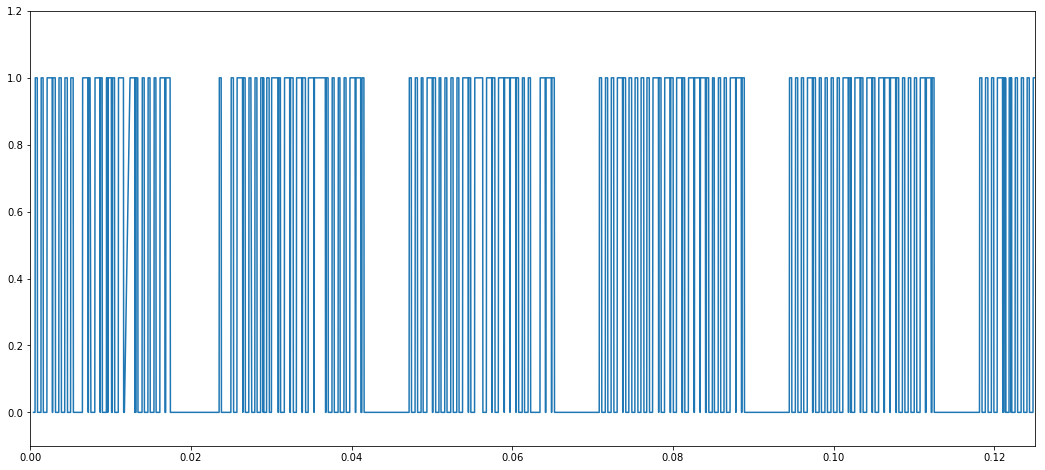

In [20]:
fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(111)
ax.plot(two_on[0], two_on[1])
ax.axis([0, .125, -.1, 1.2])
plt.show()

In [ ]:
'two_on': '0001000001010101110000110'


In [25]:
print(five_on[0][:10])
print(five_on[1][:10])

[0.000452, 0.000517, 0.000552, 0.000585, 0.000616, 0.00065, 0.000681, 0.000713, 0.000743, 0.000777]
[0, 0, 0, 0, 1, 1, 1, 1, 1, 1]


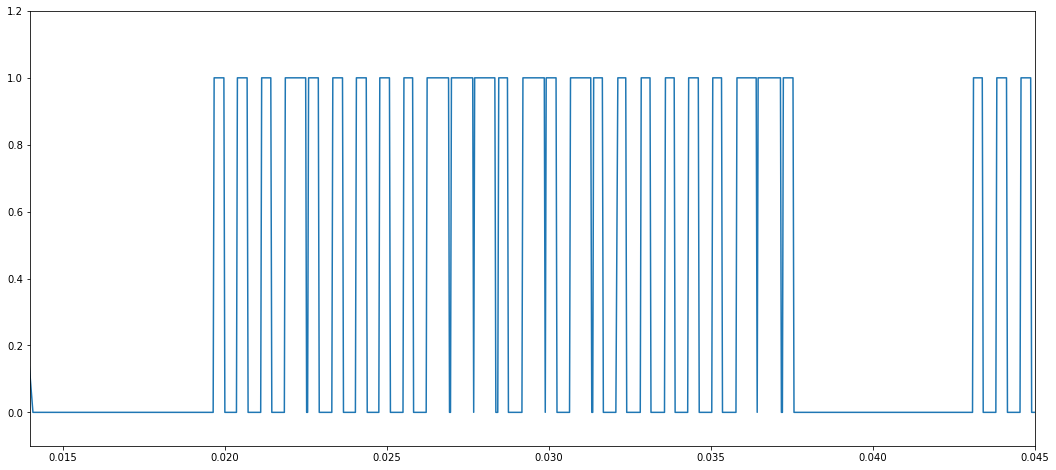

In [108]:
fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(111)
ax.plot(five_on[0], five_on[1])
ax.axis([.014, .045, -.1, 1.2])
plt.show()

In [ ]:
7,19,21,23,27,31,45,47

In [57]:
import numpy as np
timing = np.array(five_on[0])
signal = np.array(five_on[1])
a = np.where(np.roll(signal,1)!=signal)[0]

In [21]:
def get_pulses(received):
    timing = np.array(received[0])
    signal = np.array(received[1])
    a = np.where(np.roll(signal,1)!=signal)[0]
    pulses = (timing[a][1:] - timing[a][:-1])
    return pulses

In [119]:
np.max(np.where(timing[a] < .015))

36

In [117]:
timing[a][36]

0.014085

In [120]:
np.max(np.where(timing[a] <.04))

86

In [122]:
timing[a][86]

0.037574000000000003

In [123]:
timing[a][36:86]

array([ 0.014085,  0.019677,  0.020008,  0.020395,  0.020725,  0.021144,
        0.021457,  0.021874,  0.022532,  0.022592,  0.022921,  0.02334 ,
        0.023669,  0.024068,  0.024402,  0.02479 ,  0.025118,  0.025535,
        0.025833,  0.026251,  0.026942,  0.027001,  0.027688,  0.027718,
        0.028372,  0.028461,  0.02876 ,  0.029208,  0.029897,  0.029926,
        0.030259,  0.030676,  0.031332,  0.031391,  0.03169 ,  0.032137,
        0.032411,  0.032859,  0.03316 ,  0.033606,  0.033905,  0.034323,
        0.034649,  0.035067,  0.035367,  0.035814,  0.036438,  0.036467,
        0.037185,  0.037245])

In [126]:
c = (timing[a][37:86] - timing[a][36:85])
c

array([  5.59200000e-03,   3.31000000e-04,   3.87000000e-04,
         3.30000000e-04,   4.19000000e-04,   3.13000000e-04,
         4.17000000e-04,   6.58000000e-04,   6.00000000e-05,
         3.29000000e-04,   4.19000000e-04,   3.29000000e-04,
         3.99000000e-04,   3.34000000e-04,   3.88000000e-04,
         3.28000000e-04,   4.17000000e-04,   2.98000000e-04,
         4.18000000e-04,   6.91000000e-04,   5.90000000e-05,
         6.87000000e-04,   3.00000000e-05,   6.54000000e-04,
         8.90000000e-05,   2.99000000e-04,   4.48000000e-04,
         6.89000000e-04,   2.90000000e-05,   3.33000000e-04,
         4.17000000e-04,   6.56000000e-04,   5.90000000e-05,
         2.99000000e-04,   4.47000000e-04,   2.74000000e-04,
         4.48000000e-04,   3.01000000e-04,   4.46000000e-04,
         2.99000000e-04,   4.18000000e-04,   3.26000000e-04,
         4.18000000e-04,   3.00000000e-04,   4.47000000e-04,
         6.24000000e-04,   2.90000000e-05,   7.18000000e-04,
         6.00000000e-05]

In [128]:
print("delay between packets:",c[0])
print()

delay between packets: 0.005592


In [142]:
np.mean([c[1],c[3],c[5],c[9],c[11],c[13],c[15],c[17],c[25],c[29],c[33]])

0.00032027272727272774

In [144]:
np.mean([c[2],c[4],c[6],c[10],c[12],c[14],c[16],c[18],c[26],c[30],c[34]])

0.00041599999999999905

In [146]:
np.mean([c[7],c[19],c[21],c[23],c[27],c[31],c[45],c[47]])

0.00067212500000000041

In [149]:
np.mean([c[8],c[20],c[22],c[24],c[28],c[32],c[46],c[48]])

5.1875000000000272e-05

In [137]:
c[1]

0.00033100000000000143

In [136]:
c[9]

0.00032899999999999943

In [138]:
code_dict['five_on']

'0001000001110101000000110'